  1%|          | 1/100 [00:01<02:20,  1.42s/it]

optimal_policy_values_diff: 1.000


  2%|▏         | 2/100 [00:02<02:18,  1.41s/it]

optimal_policy_values_diff: 0.138


  3%|▎         | 3/100 [00:04<02:15,  1.40s/it]

optimal_policy_values_diff: 0.069


  4%|▍         | 4/100 [00:05<02:11,  1.37s/it]

optimal_policy_values_diff: 0.098


  5%|▌         | 5/100 [00:06<02:07,  1.34s/it]

optimal_policy_values_diff: 0.069


  6%|▌         | 6/100 [00:08<02:05,  1.33s/it]

optimal_policy_values_diff: 0.069


  7%|▋         | 7/100 [00:09<02:01,  1.30s/it]

optimal_policy_values_diff: 0.098


  8%|▊         | 8/100 [00:10<01:57,  1.28s/it]

optimal_policy_values_diff: 0.098


  9%|▉         | 9/100 [00:11<01:54,  1.26s/it]

optimal_policy_values_diff: 0.120


 10%|█         | 10/100 [00:12<01:52,  1.25s/it]

optimal_policy_values_diff: 0.069


 11%|█         | 11/100 [00:14<01:49,  1.23s/it]

optimal_policy_values_diff: 0.098


 12%|█▏        | 12/100 [00:15<01:47,  1.22s/it]

optimal_policy_values_diff: 0.000


 13%|█▎        | 13/100 [00:16<01:45,  1.21s/it]

optimal_policy_values_diff: 0.069


 14%|█▍        | 14/100 [00:17<01:43,  1.21s/it]

optimal_policy_values_diff: 0.000


 15%|█▌        | 15/100 [00:18<01:41,  1.20s/it]

optimal_policy_values_diff: 0.069


 16%|█▌        | 16/100 [00:20<01:40,  1.19s/it]

optimal_policy_values_diff: 0.069


 17%|█▋        | 17/100 [00:21<01:38,  1.18s/it]

optimal_policy_values_diff: 0.069


 18%|█▊        | 18/100 [00:22<01:36,  1.17s/it]

optimal_policy_values_diff: 0.069


 19%|█▉        | 19/100 [00:23<01:34,  1.17s/it]

optimal_policy_values_diff: 0.000


 20%|██        | 20/100 [00:24<01:33,  1.16s/it]

optimal_policy_values_diff: 0.000


 21%|██        | 21/100 [00:25<01:31,  1.16s/it]

optimal_policy_values_diff: 0.069


 22%|██▏       | 22/100 [00:27<01:30,  1.16s/it]

optimal_policy_values_diff: 0.000


 23%|██▎       | 23/100 [00:28<01:28,  1.15s/it]

optimal_policy_values_diff: 0.000


 24%|██▍       | 24/100 [00:29<01:27,  1.14s/it]

optimal_policy_values_diff: 0.000


 24%|██▍       | 24/100 [00:30<01:36,  1.27s/it]

optimal_policy_values_diff: 0.069
optimal_policy_values_diff have converged


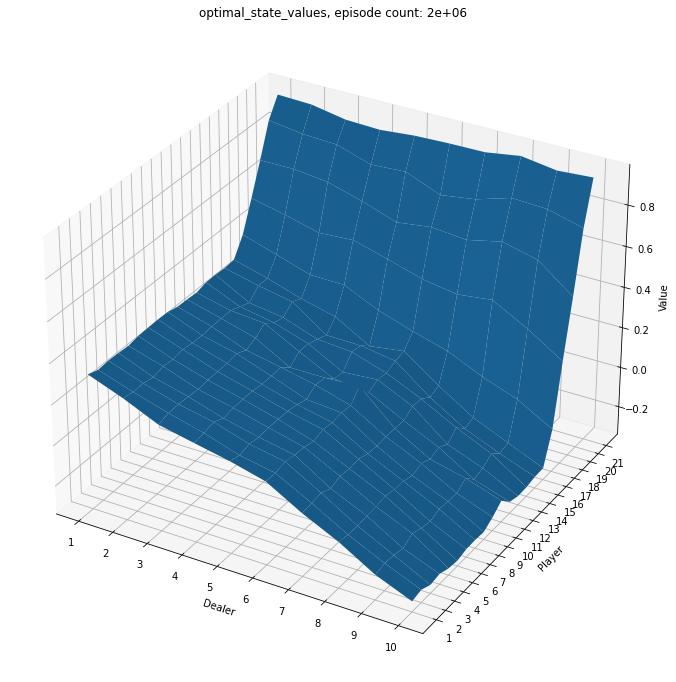

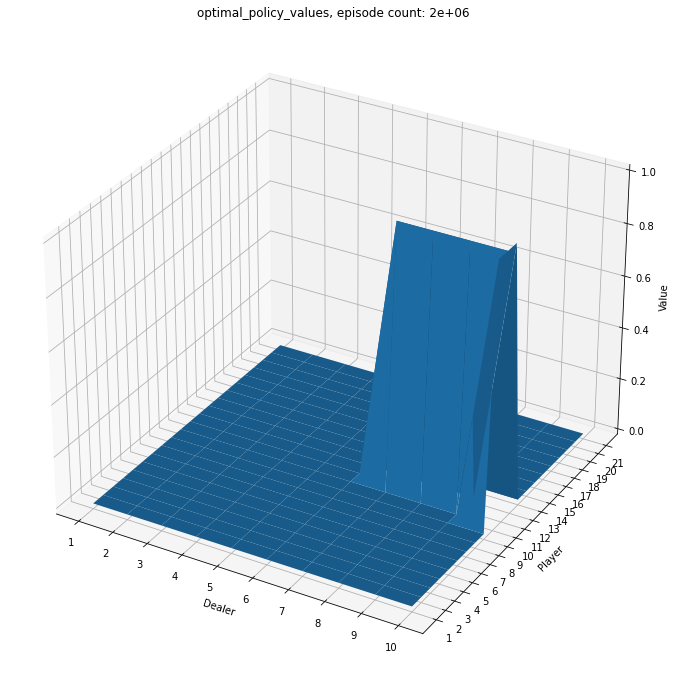

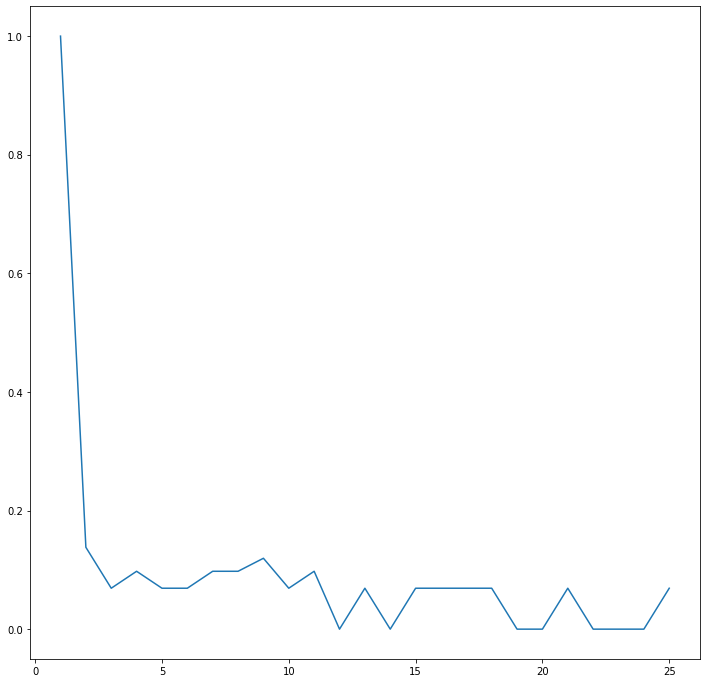

In [1]:
# %%
from math import floor
from random import random
from tqdm import trange

from game import init, step, dummy_dealer_stick_policy
from plot import plot_2d_value_map, plot_line
from value_map import ValueMap

EPISODES = int(1e5)
BATCH = 100

ACTIONS = ["stick", "hit"]

"""State Value V: state -> expected return

state values are learnt from all the trajectory samples
from the given state
followed by all possible actions given by the policy
"""
state_values = ValueMap()

"""Action Value Q: state, action -> expected return

action values are learnt from all the trajectory samples
from the action on the given state

the mean expectation (average mean) also tells us
the overall win ratio of the policy at all states
when the number of the training episodes is large enough
to weight in more later policies
"""
action_values = ValueMap()

"""Optimal State Values V*: state -> best action value
"""
optimal_state_values = ValueMap()
"""Optimal Policy Pi*: state -> best value action index
"""
optimal_policy_values = ValueMap()


def get_best_action(state_key):
    possible_action_values = [
        action_values.get((*state_key, action_index))
        for action_index in range(len(ACTIONS))
    ]
    best_action_value = max(possible_action_values)
    best_action_index = possible_action_values.index(best_action_value)
    return best_action_index, best_action_value


def player_policy(state):
    """Policy Function: state -> action_index

    epsilon-greedy policy is used here
    to allow a chance (epsilon) to explore random actions
    so that exploration and exploitation is balanced
    during the playout learning

    epsilon is gradually diminishing to 0
    so that when training samples are sufficiently
    the policy converges to an optimal policy
    choosing the action with max action value

    the optimal policy:
    pi'(s) = argmax_{a in A} Q(s,a)

    throughout the training samples
    action value function Q is converging to the true mean
    """
    state_key = (state["dealer"], state["player"])

    best_action_index, _ = get_best_action(state_key)

    # exploration gradually decreases with more samples
    # we use a constant factor N here
    # as believed that when sample size of a state
    # is significant its value is close to the true value
    #
    # in order to let the sample szie be significant enough
    # it needs to satisfy that all possible subsequent trajectories
    # from a state have been sampled enough
    #
    # here mean state_count = episodes_count / possible_states_count
    # possible_states_count = 10*21
    # state_count ~ EPISODES*BATCH/420
    # exploration = K / K + BATCH(n) ~ [1, K/K+BATCH]
    K = 0.5 * BATCH
    N = EPISODES / 420 * K
    state_count = state_values.count(state_key)
    exploration_rate = N / (N + state_count)

    if random() < exploration_rate:
        return floor(random() * len(ACTIONS))
    else:
        return best_action_index


def learn_episode(sequence, reward):
    for [state, action_index] in sequence:

        state_key = (state["dealer"], state["player"])
        state_values.learn(state_key, reward)

        action_key = (*state_key, action_index)
        action_values.learn(action_key, reward)


def playout():
    sequence = []

    state = init()

    while state["reward"] is None:
        player_action_index = player_policy(state)
        sequence.append([state, player_action_index])

        player_stick = player_action_index == ACTIONS.index("stick")
        if player_stick:
            break

        state = step(state, player_stick)

    while state["reward"] is None:
        player_stick = True
        dealer_stick = dummy_dealer_stick_policy(state)
        state = step(state, player_stick, dealer_stick)

    reward = state["reward"]

    return sequence, reward


def set_optimal():

    ALL_STATE_KEYS = [
        (dealer, player) for player in range(1, 22) for dealer in range(1, 11)
    ]

    for state_key in ALL_STATE_KEYS:

        best_action_index, best_action_value = get_best_action(state_key)

        optimal_state_values.set(state_key, best_action_value)
        optimal_policy_values.set(state_key, best_action_index)


def record_metrics(metrics_history, metrics_instance):
    for value_map_name in metrics_history.keys():
        value_map = metrics_instance[value_map_name]
        for method in metrics_history[value_map_name].keys():
            metrics = getattr(value_map, method)()
            metrics_history[value_map_name][method].append(metrics)
            print(f"{value_map_name}_{method}: {metrics:.3f}")

            if method == "diff":
                value_map.backup()


def check_convergence(metrics_history, value_map_name, metrics_name, threshold):
    last_3 = metrics_history[value_map_name][metrics_name][-4:-1]

    if len(last_3) < 3:
        return False

    last_3_mean = sum(last_3) / len(last_3)

    if last_3_mean < threshold:
        print(f"{value_map_name}_{metrics_name} have converged")
        return True
    else:
        return False


def train():

    metrics_history = {
        "optimal_policy_values": {
            "diff": [],
        },
    }

    metrics_instance = {
        "optimal_policy_values": optimal_policy_values,
    }

    episodes_count = 0

    for _ in trange(BATCH, leave=True):

        for _ in range(EPISODES):
            sequence, reward = playout()
            learn_episode(sequence, reward)

        episodes_count += EPISODES
        set_optimal()

        record_metrics(metrics_history, metrics_instance)

        if check_convergence(metrics_history, "optimal_policy_values", "diff", 0.001):
            break

    plot_2d_value_map(optimal_state_values, "optimal_state_values", episodes_count)
    plot_2d_value_map(optimal_policy_values, "optimal_policy_values", episodes_count)
    plot_line(metrics_history["optimal_policy_values"]["diff"])


try:
    train()
    action_values.save("optimal_action_values.json")
except Exception as e:
    print(e)
